 Volterra NMSE: -37.59439619271327 dB
Using cpu device
Epoch  10/10  Loss=1.2404e+00  Valid Loss=1.3649e-01  LR=1.00e-03

Best model from epoch 10 with validation loss: 1.3649e-01
Test NMSE: -26.53 dB


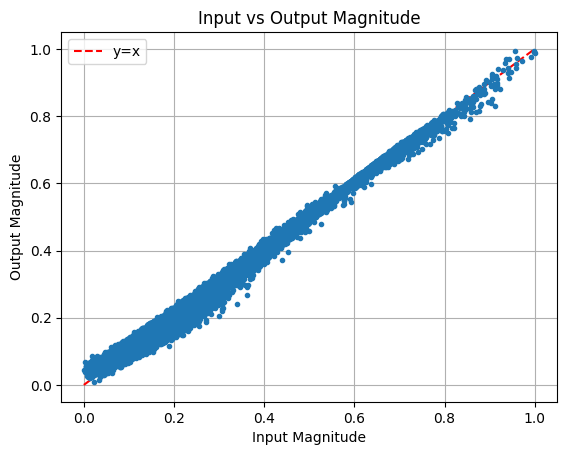

In [1]:
from sparseDPD import Volterra
from sparseDPD import Dataset
from sparseDPD import Datapath
from sparseDPD import DataManager
from sparseDPD import NeuralNetwork
from sparseDPD import DeltaGRUNetwork


simpleDataManager = DataManager(filepath='PA_IO.mat', num_training_points=10000, num_validaiton_points=2000, num_test_points=2000)

# Setup a volterra model and a volterra inverse
volterra_forward_model = Volterra(num_nl_orders=5, num_memory_levels=3, dataset=simpleDataManager.training_dataset)
volterra_invserse_model = Volterra(num_nl_orders=5, num_memory_levels=3, dataset=simpleDataManager.training_dataset)

print(f" Volterra NMSE: {volterra_forward_model.calculate_volterra_nmse(simpleDataManager.test_dataset)} dB")
training_dataset = simpleDataManager.training_dataset

# Traing small Inverse Model 
simple_nn_inv = NeuralNetwork(num_memory_levels=3, model_type='PNTDNN', forward_model=False)
train_losses, valid_losses, best_epoch = simple_nn_inv.get_best_model(num_epochs=10, training_dataset=training_dataset, validation_dataset=simpleDataManager.validation_dataset, learning_rate=1e-3)

# Create datapath with volterra forward model and nn inverse model
datapath = Datapath(forward_model=volterra_forward_model, inverse_model=simple_nn_inv)
# Process test data through datapath
test_dataset = datapath.process(simpleDataManager.test_dataset.input_data)
# Calculate NMSE
nmse = test_dataset.calculate_nmse()
print(f"Test NMSE: {nmse:.2f} dB")
# Plot input vs output magnitude
Datapath.plot_signals(test_dataset)

In [2]:
# Test NN forward performance
forward_nn = NeuralNetwork(num_memory_levels=3, model_type='PNTDNN_Deep', forward_model=True)
train_losses_fwd, valid_losses_fwd, best_epoch_fwd = forward_nn.get_best_model(num_epochs=100, training_dataset=simpleDataManager.training_dataset, validation_dataset=simpleDataManager.validation_dataset, learning_rate=5e-4)
# Print NMSE for forward model
fwd_nmse = forward_nn.calculate_forward_nmse(simpleDataManager.test_dataset)
print(f"NN Forward Model NMSE: {fwd_nmse:.2f} dB")

Using cpu device
Epoch  10/100  Loss=1.8240e+00  Valid Loss=1.6451e-01  LR=5.00e-04
Epoch  20/100  Loss=2.5268e-01  Valid Loss=4.6865e-02  LR=5.00e-04
Epoch  30/100  Loss=1.1589e-01  Valid Loss=2.2753e-02  LR=5.00e-04
Epoch  40/100  Loss=9.3284e-02  Valid Loss=3.4740e-02  LR=5.00e-04
Epoch  50/100  Loss=8.4506e-02  Valid Loss=1.7024e-02  LR=5.00e-04
Epoch  60/100  Loss=8.2343e-02  Valid Loss=4.7710e-02  LR=5.00e-04
Epoch  70/100  Loss=8.2932e-02  Valid Loss=1.6017e-02  LR=5.00e-04
Epoch  80/100  Loss=1.0326e-01  Valid Loss=1.6879e-02  LR=5.00e-04
Epoch  90/100  Loss=7.3581e-02  Valid Loss=1.6189e-02  LR=2.50e-04
Epoch 100/100  Loss=7.2909e-02  Valid Loss=1.4807e-02  LR=2.50e-04

Best model from epoch 96 with validation loss: 1.4412e-02
NN Forward Model NMSE: -31.72 dB


In [ ]:
# --- DeltaGRU forward model: train + NMSE on test set (assumes DeltaGRUNetwork is in sparseDPD) ---

from sparseDPD import DeltaGRUNetwork

# Train DeltaGRU forward model
delta_fwd = DeltaGRUNetwork(
    forward_model=True,
    hidden_size=64,
    num_layers=1,
    thx=0.0, thh=0.0,          # start at 0 for best accuracy; increase later for sparsity
    use_tcn_skip=True,
    seq_len=256,
    seq_hop=256,
    batch_size=256
)

train_losses_dgru, valid_losses_dgru, best_epoch_dgru = delta_fwd.get_best_model(
    num_epochs=400,
    training_dataset=simpleDataManager.training_dataset,
    validation_dataset=simpleDataManager.validation_dataset,
    learning_rate=1e-1
)

# Evaluate NMSE on test set
dgru_nmse = delta_fwd.calculate_forward_nmse(simpleDataManager.test_dataset)
print(f"DeltaGRU Forward Model NMSE: {dgru_nmse:.2f} dB")

# Compare to baseline forward_nn if it exists
try:
    print(f"Baseline NN Forward Model NMSE: {fwd_nmse:.2f} dB")
    print(f"Delta vs baseline NN: {dgru_nmse - fwd_nmse:+.2f} dB (negative is better)")
except NameError:
    pass


Using cpu device
Epoch  10/400  Loss=1.4312e+01  Valid=3.9044e-01  LR=1.00e-01
Epoch  20/400  Loss=3.4789e+00  Valid=4.0619e-01  LR=1.00e-01
Epoch  30/400  Loss=3.3964e+00  Valid=5.3017e-01  LR=5.00e-02
Epoch  40/400  Loss=2.0615e+00  Valid=2.6392e-01  LR=5.00e-02
